# I - Fluxonium Qubit using SCQubits

In [2]:
import scqubits as sc

In [3]:
fluxonium = sc.Fluxonium(EJ = 8.9,
                               EC = 2.5,
                               EL = 0.5,
                               flux = 0,
                               cutoff = 110)


In [4]:
evals_scqubits = fluxonium.eigenvals()
evals_scqubits -= evals_scqubits[0]
evals_scqubits

array([ 0.        ,  8.75844526,  8.97955262, 11.00203435, 16.93299002,
       19.57185963])

# II - Fluxonium Qubit using QuTiP

In [5]:
import qutip as qt
import numpy as np

In [6]:
truncation_level = 110 # max dimension to keep in the matrices

In [7]:
creation = qt.create(truncation_level)  # Creation and destruction operators
destruction = qt.destroy(truncation_level)

We have the following Hamiltonian for the circuit (that can be found by wrinting the lagrangian, etc.) :

$$
H = \frac 1 {2C} q^2 + \frac 1 {2L} \phi^2 - \frac {\phi_0^2} {L_C} \cos \bigg(\frac \phi {\phi_0} \bigg)
$$

Where $$q = C\dot\phi$$ $$\phi_0 = \frac \hbar {2e}$$

If we now replace $C$ and $L$ with $C = \frac {e^2} {2E_C}$ and $L = \frac {\phi_0^2} {E_L}$, and use $E_J = \frac {\phi_0^2} {L_C}$, we get the following expression :

$$
H = \frac {E_C} {e^2} q^2 + \frac {E_L} {2\phi_0^2} \phi^2 - E_J \cos \bigg(\frac \phi {\phi_0} \bigg)
$$

Let us define :
$$\hat n := \frac {\hat q} {2e}$$
$$\hat \varphi := \frac {\hat \phi} {\phi_0}$$

So that : 
$$
\hat H = 4E_C \hat n^2 + \frac {E_L} 2 \hat\varphi^2 - E_J \cos (\hat \varphi )
$$

Finally, let us define the destruction operator :
$$ \hat a := \frac 1 2 \bigg(\frac {E_L} {2E_C}\bigg)^{\frac 1 4}\hat\varphi + i\bigg(\frac {2E_C} {E_L} \bigg)^{\frac 1 4}\hat n $$

If we define $\varepsilon := \big(\frac {E_L} {2E_C}\big)^{\frac 1 4}$, this boils down to :
$$ \hat a = \frac 1 2 \varepsilon\hat\varphi + i\frac 1 {\varepsilon}\hat n $$

We then have, since $[\hat \varphi, \hat n] = i$ $$[\hat a, \hat a^\dag] = 1$$

And the Hamiltonian can be rewritten as :
$$
\hat H = \hbar \omega \bigg(\hat a^\dag \hat a + \frac 1 2\bigg) - E_J \cos \bigg( \frac 1 \varepsilon (\hat a + \hat a^\dag) \bigg)
$$

as $\hbar\omega = \sqrt{8E_CE_L}$ if $\omega = \frac 1 {\sqrt{LC}}$.

This is the formula that we will implement. If we wish, we can also add an external flux $\varphi_{ext}$ between $0$ and $2\pi$ inside the cosinus.

In [8]:
def hamiltonian_qutip(EL,EC,EJ, flux=0) :
    '''
    A simple funciton that returns the hamiltonian of a fluxonium circuit
    '''

    epsilon = (EL/(2*EC))**(1/4)

    return np.sqrt(8*EC*EL) * (creation*destruction + 1/2)  - EJ * ((creation + destruction)/epsilon - flux).cosm()

In [9]:
evals_qutip = hamiltonian_qutip(0.5, 2.5, 8.9).eigenenergies()
evals_qutip -= evals_qutip[0]
evals_qutip

array([  0.        ,   8.75844526,   8.97955262,  11.00203435,
        16.93299002,  19.57185963,  23.15002884,  27.70870397,
        31.70268214,  34.76565983,  36.03701914,  37.72943458,
        40.99428963,  44.27996731,  47.37513765,  50.59527123,
        54.07646371,  57.69297526,  61.35602692,  65.05558755,
        68.76242336,  72.39813185,  75.81737225,  78.75812995,
        81.04802062,  83.15842762,  85.70321504,  88.63628456,
        91.68592589,  94.76946121,  97.9131342 , 101.14349971,
       104.4553389 , 107.82971847, 111.25217189, 114.71407427,
       118.20689999, 121.71869942, 125.23361895, 128.73116866,
       132.18349262, 135.54997248, 138.77100414, 141.77216412,
       144.51315529, 147.08059436, 149.67060105, 152.41485406,
       155.3066936 , 158.28964551, 161.32958524, 164.41713178,
       167.55381796, 170.7391154 , 173.96895658, 177.23854661,
       180.54287835, 183.87722083, 187.23804645, 190.61988048,
       194.020645  , 197.4267805 , 200.84567898, 204.24

# III - Fluxonium Qubit using Numpy

In [10]:
import numpy as np
import numpy.linalg as alg
from scipy.linalg import cosm

In [11]:
truncation_level = 110 # max dimension to keep in the matrices

Here, we will use the fact that the eigenvalues of $\hat H$ can be explored using the jump operators, meaning that $\hat a |n\rangle$ is associated to the eigenvalue $n-1$, and $\hat a^\dag |n\rangle$ to the eigenvalue $n+1$

We have :
$$
\begin{aligned}
\|\hat a | n \rangle \|^2 & = \langle n | \hat a^\dag \hat a | n \rangle \\
& = \langle n |n| n \rangle \\
& = n
\end{aligned}
$$
Same goes for the other one.
Therefore, if we normalize $\hat a |n\rangle$ and $\hat a^\dag |n\rangle$, we get the relationships :

$$
\begin{equation}
    \begin{cases}
        \hat a |n\rangle = \sqrt n | n-1 \rangle \\
        \hat a^\dag |n\rangle= \sqrt {n+1} | n+1 \rangle
    \end{cases}\,.
\end{equation}
$$

From these relationships we obtain the form of the $\hat a$ and $\hat a^\dag$ matrices, truncated to order $d$, in the Fock basis.

In [12]:
destruction_np = np.zeros((truncation_level,truncation_level))

for n in range (1,truncation_level): destruction_np[n-1,n] = np.sqrt(n)

creation_np = destruction_np.T #Since it is a real matrix in the Fock basis.

In [13]:
def hamiltonian_numpy(EL,EC,EJ, flux=0) :
    '''
    A simple funciton that returns the hamiltonian of a fluxonium circuit
    '''

    epsilon = (EL/(2*EC))**(1/4)

    return np.sqrt(8*EC*EL) * (np.dot(creation_np,destruction_np) + np.eye(truncation_level)*1/2) - EJ * cosm((creation_np + destruction_np)/epsilon - flux)

In [14]:
evals_numpy = np.sort(alg.eigvals(hamiltonian_numpy(0.5, 2.5, 8.9)))
evals_numpy -= evals_numpy[0]
evals_numpy

array([  0.        ,   8.75844526,   8.97955262,  11.00203435,
        16.93299002,  19.57185963,  23.15002884,  27.70870397,
        31.70268214,  34.76565983,  36.03701914,  37.72943458,
        40.99428963,  44.27996731,  47.37513765,  50.59527123,
        54.07646371,  57.69297526,  61.35602692,  65.05558755,
        68.76242336,  72.39813185,  75.81737225,  78.75812995,
        81.04802062,  83.15842762,  85.70321504,  88.63628456,
        91.68592589,  94.76946121,  97.9131342 , 101.14349971,
       104.4553389 , 107.82971847, 111.25217189, 114.71407427,
       118.20689999, 121.71869942, 125.23361895, 128.73116866,
       132.18349262, 135.54997248, 138.77100414, 141.77216412,
       144.51315529, 147.08059436, 149.67060105, 152.41485406,
       155.3066936 , 158.28964551, 161.32958524, 164.41713178,
       167.55381796, 170.7391154 , 173.96895658, 177.23854661,
       180.54287835, 183.87722083, 187.23804645, 190.61988048,
       194.020645  , 197.4267805 , 200.84567898, 204.24

# IV - Comparaison

In [19]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [16]:
def compute_energies(EL,EC,EJ, start_flux=-np.pi/6, end_flux=np.pi/6, nbpoints = 100) :

    Phases = np.linspace(start_flux,end_flux, nbpoints)
    Energies=np.empty((18,Phases.size))

    for i,phase in enumerate(Phases) :
        evals_numpy = np.sort(alg.eigvals(hamiltonian_numpy(EL, EC, EJ, flux=phase)))
        Energies[:6,i] = evals_numpy[:6] - evals_numpy[0]

        evals_qutip = hamiltonian_qutip(EL, EC, EJ, flux=phase).eigenenergies()
        Energies[6:12,i] = evals_qutip[:6] - evals_qutip[0]

        evals_scqubits = sc.Fluxonium(EJ = EJ, EC = EC, EL = EL, flux = phase, cutoff = 110).eigenvals()
        Energies[12:,i] = evals_scqubits[:6] - evals_scqubits[0]

    return Phases,Energies

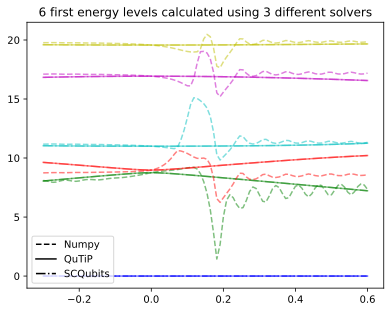

In [23]:
Phases, Energies = compute_energies(0.5, 2.5, 8.9, -0.3, 0.6)

Colors = ['b','g','r','c','m','y']

for i in range(6):
    plt.plot(Phases, Energies[i,:], linestyle = '--', c=Colors[i], alpha=0.5)
    plt.plot(Phases, Energies[i+6,:], linestyle = '-', c=Colors[i], alpha=0.5)
    plt.plot(Phases, Energies[i+6,:], linestyle = '-.', c=Colors[i], alpha=0.5)


plt.legend(handles=[mlines.Line2D([], [], color='black', linestyle='--',label = "Numpy"),mlines.Line2D([], [], color='black', linestyle='-',label = "QuTiP"),mlines.Line2D([], [], color='black', linestyle='-.',label = "SCQubits")])
plt.title("6 first energy levels calculated using 3 different solvers")

plt.show()